In [1]:
import os
import sys
from pathlib import Path
import warnings
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import yaml
import importlib
import numpy as np
import gvar as gv
import platform
import pprint
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

# local imports 
import xpt.fit_analysis as xfa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/home/gmoney/lqcd/hyperon-xpt-master


In [2]:
from importlib import reload
importlib.reload(xfa)
importlib.reload(i_o)
importlib.reload(fit)
importlib.reload(priors)

<module 'xpt.priors' from '/home/gmoney/lqcd/hyperon-xpt-master/xpt/priors.py'>

In [3]:
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd'
else:
    base_dir = '/home/gmoney/lqcd'

data_dir = os.path.join(base_dir, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
# bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
prior = priors.get_prior(units='mev')
input_output = i_o.InputOutput(project_path=data_dir)
data, ensembles = input_output.get_data(units='phys')
new_prior = input_output.make_prior(data=data,prior=prior)
phys_point_data = input_output.get_data_phys_point()
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
lam_sigma_models = models['models']['lam_sigma_system']


In [11]:
model_info=xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo']

extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=model_info, prior=new_prior,project_path=data_dir)
extrap_analysis.plot_params(yparam='xi')
posterior = {}
print(extrap_analysis.extrapolated_mass)
print(extrap_analysis)

{'xi': 1347(18), 'xi_st': 1553(25)}

---
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -149.82

Parameters:
       m_{xi,0}       1327 (21)      [    1000 (400) ]  
         s_{xi}       1.22 (53)      [     0.0 (2.0) ]  
       b_{xi,4}       0.2 (1.9)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.35 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
      g_{xi,xi}   0.009 (3.976)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.1 (2.4)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1529 (29)      [    1300 (400) ]  
       a_{xi,4}      -0.8 (1.7)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.57 (64)      [     0.0 (2.0) ]  
    b_{xi_st,4}       0.6 (4.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.12 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}

{
    'xi':
    array([1410(13), 1282(12), 1318(11), 1370(11), 1388(11), 1411(12),
           1271.5(9.6), 1283(10), 1318.6(9.9), 1336(10), 1358(10),
           1258.0(8.6), 1257.6(8.5), 1294.3(8.7), 1288.1(9.1), 1302.1(9.7),
           1327.5(9.8)], dtype=object),
    'xi_st':
    array([1643(18), 1527(16), 1563(19), 1620(21), 1631(27), 1671(15),
           1535(13), 1555(12), 1581(13), 1599(14), 1622(13), 1528(11),
           1518(13), 1557(10), 1554(11), 1555(13), 1584(13)], dtype=object),
} fit_result
[1347(18) 1343(17) 1339(16) 1335(15) 1331(15) 1327(14) 1324(13) 1320(12)
 1317(11) 1313(11) 1310(10) 1307.0(9.6) 1303.9(9.1) 1300.9(8.6)
 1297.9(8.2) 1295.1(7.8) 1292.4(7.4) 1289.7(7.1) 1287.2(6.9) 1284.7(6.6)
 1282.3(6.4) 1280.0(6.3) 1277.8(6.1) 1275.7(6.0) 1273.7(5.9) 1271.8(5.8)
 1269.9(5.7) 1268.2(5.7) 1266.5(5.6) 1264.9(5.6) 1263.5(5.5) 1262.1(5.5)
 1260.8(5.5) 1259.5(5.4) 1258.4(5.4) 1257.4(5.4) 1256.4(5.4) 1255.6(5.4)
 1254.8(5.4) 1254.1(5.5) 1253.6(5.6) 1253.1(5.7) 1252.7(5.8)

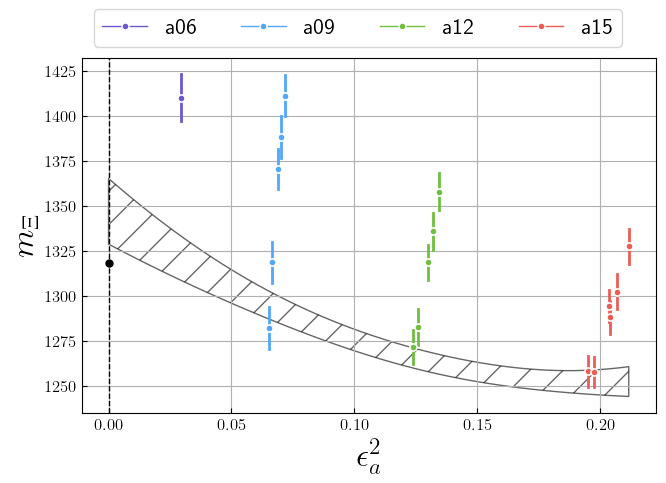

In [12]:
import importlib
importlib.reload(xfa)

model_info=xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,project_path=data_dir, empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)


xi_fit = my_fit.fit
# begin plotting routine 
plt.axes([0.145,0.145,0.85,0.85])
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

latt_spacing = {'06': gv.gvar('0.04009(18)'), '09': gv.gvar('0.09209(28)'), '12': gv.gvar('0.17016(37)'),
           '15': gv.gvar('0.25206(32)'), '00': gv.gvar('0(0)')}
param = 'a'
yparam = 'xi'
xi = {}

for j, xx in enumerate(reversed(latt_spacing)):    
    phys_data = phys_point_data
    phys_data['eps2_a'] = latt_spacing[xx]
    if param == 'a':
        eps2_a_arr = [data['eps2_a']] 
        xi['eps2_a'] = np.linspace(0, gv.mean(np.max(eps2_a_arr)))
x_fit = xi['eps2_a']

print(xi_fit.y,'fit_result')
posterior = xi_fit.p

xi_a = my_fit.get_fitfcn(data=phys_data,particle='xi',xdata=xi)
xi_st_a = my_fit.get_fitfcn(data=phys_data,particle='xi_st',xdata=xi)

y_fit = xi_a
print(y_fit,'yfit')
print(x_fit)

pm = lambda g, k : gv.mean(g) + k *gv.sdev(g)
plt.fill_between(pm(x_fit, 0), pm(y_fit, -1), pm(y_fit, +1), facecolor='None', edgecolor='k', alpha=0.6, hatch='/')

# now plotting the shifted fit parameters
# break here for debugging # 
# yparam = 'xi'
param = 'eps2_a'
added_labels = set()
x = {}
y = {}
baryon_latex = {
            'sigma': '\Sigma',
            'sigma_st': '\Sigma^*',
            'xi': '\Xi',
            'xi_st': '\Xi^*',
            'lambda': '\Lambda'
        }
for ens in ensembles:
    if param == 'eps2_a':
        x = data['eps2_a']
        y[ens] = my_fit.shift_latt_to_phys(ens=ens,phys_params=['eps_pi','d_eps2_s'],observable='xi')
        xlabel = '$\epsilon_a^2$'

        print(y,'shift_y')
for i,ens in enumerate(ensembles):
    C = gv.evalcov([x[i], y[ens]])
    eVe, eVa = np.linalg.eig(C)
    color_key = ensembles[i][:3]
    color = colormap[color_key]
    label = f'{color_key.lower()}'

    for e, v in zip(eVe, eVa.T):
        plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                [gv.mean(y[ens])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[ens])],
                    alpha=1.0, lw=2, color=color)

        if label not in added_labels:
            plt.plot(gv.mean(x[i]), gv.mean(y[ens]), 
                    marker='o', mec='w', zorder=3, color=color, label=label)
            added_labels.add(label)
        else:
            plt.plot(gv.mean(x[i]), gv.mean(y[ens]), 
                    marker='o', mec='w', zorder=3, color=color)
    

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
    ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
plt.grid()
plt.xlabel(xlabel, fontsize = 24)
if yparam ==   'xi':
    phys_point_yparam = gv.mean(np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']]))
elif yparam == 'xi_st':
    phys_point_yparam = gv.mean(np.mean([gv.gvar(g) for g in ['1531.80(32)', '1535.0(0.6)']]))
elif yparam == 'lambda':
    phys_point_yparam = gv.mean(gv.gvar(1115.683, 0.006))
elif yparam == 'sigma':
    phys_point_yparam =  np.mean([gv.gvar(g) for g in ['1189.37(07)', '1192.642(24)', '1197.449(30)']]),
elif yparam == 'sigma_st':
    phys_point_yparam = np.mean([gv.gvar(g) for g in ['1382.80(35)', '1383.7(1.0)', '1387.2(0.5)']])
phys_point_xparam = 0.0
if yparam in baryon_latex.keys():
    latex_baryon = baryon_latex[yparam]
    label = f'$m_{{{latex_baryon}}}$'
plt.ylabel(label, fontsize = 24)

plt.plot(phys_point_xparam, phys_point_yparam, marker='o', color='black', zorder=4)
plt.axvline(phys_point_xparam, ls='--', color='black', label=label)

fig = plt.gcf()
plt.show()
plt.close()
# return fig 



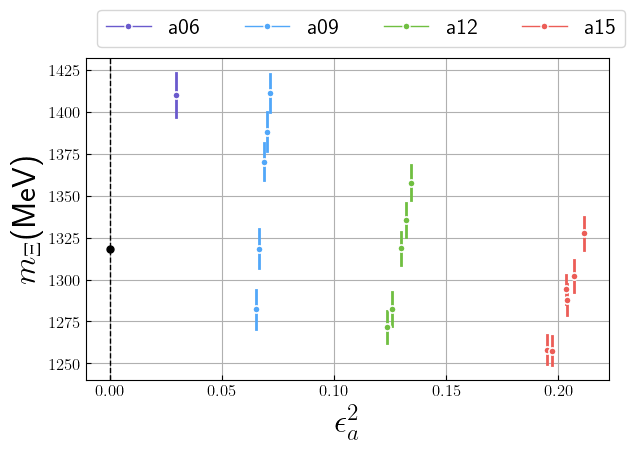

Model: xi:xi_st:d_n2lo:l_lo
Least Square Fit:
  chi2/dof [dof] = 0.43 [34]    Q = 1    logGBF = -147.7

Parameters:
       m_{xi,0}       1323 (19)      [    1000 (400) ]  
         s_{xi}       1.40 (17)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.66 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.33 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.5 (1.2)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1530 (27)      [    1300 (400) ]  
     s_{xi,bar}       1.52 (23)      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.12 (81)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -3.8 (1.3)      [     0.0 (5.0) ]  
       eps2_a 0   0.029618 (41)      [ 0.029618 (41) ]  
              1   0.065325 (70)      [ 0.065325 (70) ]  
              2   0.066506 (83)      [ 0.066506 (83) ]  
              3    0.06877 (16)      [  0.06877 (16) ]  
              4    0.06998 (19)      [  0.06998 (19) ]  
              5    0.07161 (2

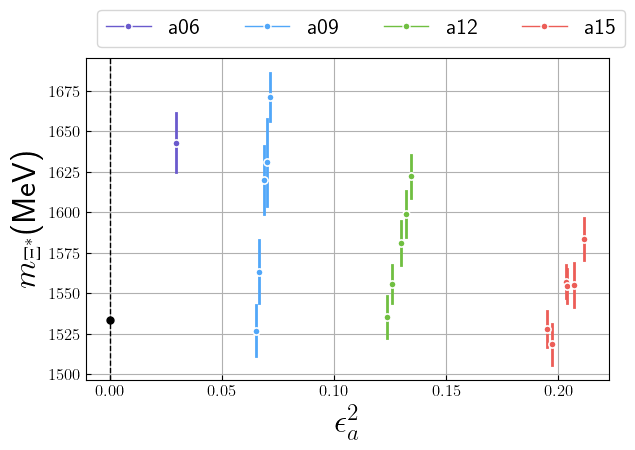

Model: xi:xi_st:d_n2lo:l_lo
Least Square Fit:
  chi2/dof [dof] = 0.43 [34]    Q = 1    logGBF = -147.7

Parameters:
       m_{xi,0}       1323 (19)      [    1000 (400) ]  
         s_{xi}       1.40 (17)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.66 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.33 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.5 (1.2)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1530 (27)      [    1300 (400) ]  
     s_{xi,bar}       1.52 (23)      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.12 (81)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -3.8 (1.3)      [     0.0 (5.0) ]  
       eps2_a 0   0.029618 (41)      [ 0.029618 (41) ]  
              1   0.065325 (70)      [ 0.065325 (70) ]  
              2   0.066506 (83)      [ 0.066506 (83) ]  
              3    0.06877 (16)      [  0.06877 (16) ]  
              4    0.06998 (19)      [  0.06998 (19) ]  
              5    0.07161 (2

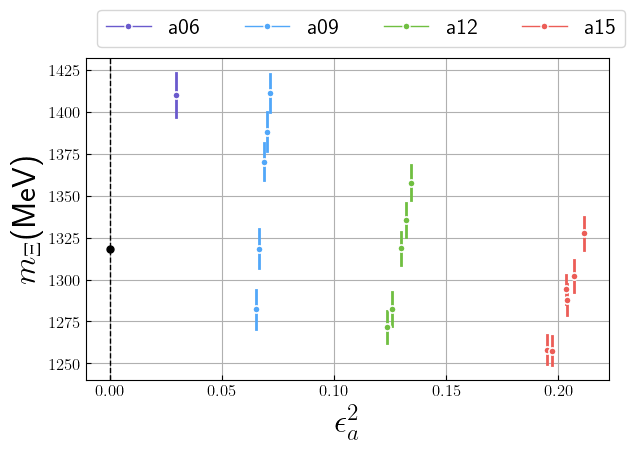

Model: xi:xi_st:d_n2lo:l_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -148.73

Parameters:
       m_{xi,0}       1325 (20)      [    1000 (400) ]  
         s_{xi}       1.34 (23)      [     0.0 (2.0) ]  
       b_{xi,4}       0.6 (1.6)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.34 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1528 (28)      [    1300 (400) ]  
     s_{xi,bar}       1.57 (34)      [     0.0 (2.0) ]  
    b_{xi_st,4}      -0.3 (2.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.10 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
       eps2_a 0   0.029618 (41)      [ 0.029618 (41) ]  
              1   0.065325 (70)      [ 0.065325 (70) ]  
              2   0.066506 (83)      [ 0.066506 (83) ]  
              3    0.06877

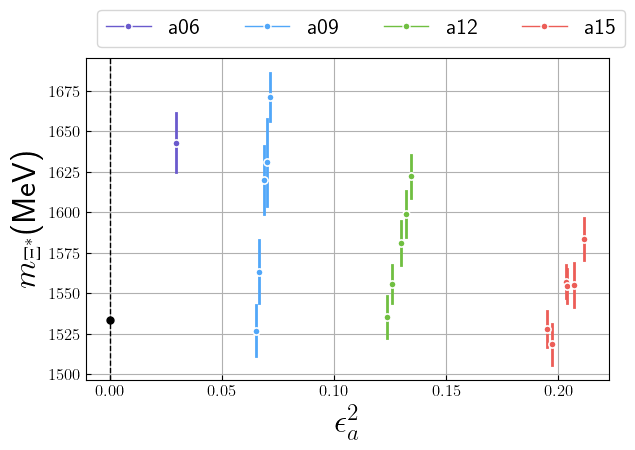

Model: xi:xi_st:d_n2lo:l_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -148.73

Parameters:
       m_{xi,0}       1325 (20)      [    1000 (400) ]  
         s_{xi}       1.34 (23)      [     0.0 (2.0) ]  
       b_{xi,4}       0.6 (1.6)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.34 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1528 (28)      [    1300 (400) ]  
     s_{xi,bar}       1.57 (34)      [     0.0 (2.0) ]  
    b_{xi_st,4}      -0.3 (2.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.10 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
       eps2_a 0   0.029618 (41)      [ 0.029618 (41) ]  
              1   0.065325 (70)      [ 0.065325 (70) ]  
              2   0.066506 (83)      [ 0.066506 (83) ]  
              3    0.06877

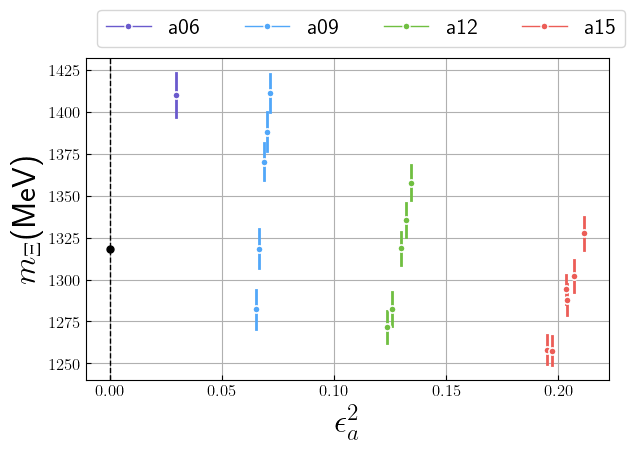

Model: xi:xi_st:d_n2lo:l_n2lo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -149.82

Parameters:
       m_{xi,0}       1327 (21)      [    1000 (400) ]  
         s_{xi}       1.22 (53)      [     0.0 (2.0) ]  
       b_{xi,4}       0.2 (1.9)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.35 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
      g_{xi,xi}   0.009 (3.976)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.1 (2.4)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1529 (29)      [    1300 (400) ]  
       a_{xi,4}      -0.8 (1.7)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.57 (64)      [     0.0 (2.0) ]  
    b_{xi_st,4}       0.6 (4.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.12 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}    

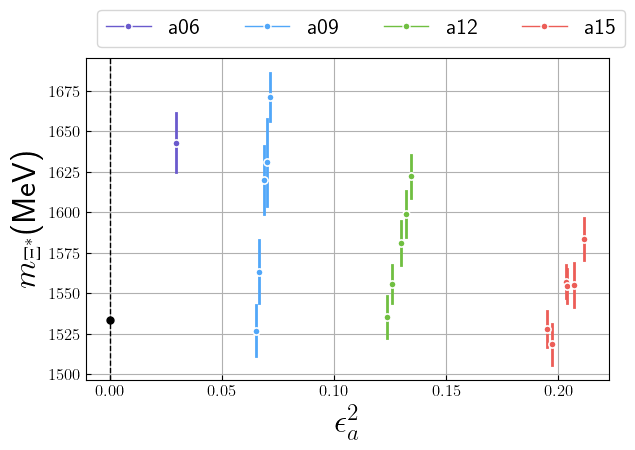

Model: xi:xi_st:d_n2lo:l_n2lo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -149.82

Parameters:
       m_{xi,0}       1327 (21)      [    1000 (400) ]  
         s_{xi}       1.22 (53)      [     0.0 (2.0) ]  
       b_{xi,4}       0.2 (1.9)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.35 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
      g_{xi,xi}   0.009 (3.976)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.1 (2.4)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1529 (29)      [    1300 (400) ]  
       a_{xi,4}      -0.8 (1.7)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.57 (64)      [     0.0 (2.0) ]  
    b_{xi_st,4}       0.6 (4.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.12 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}    

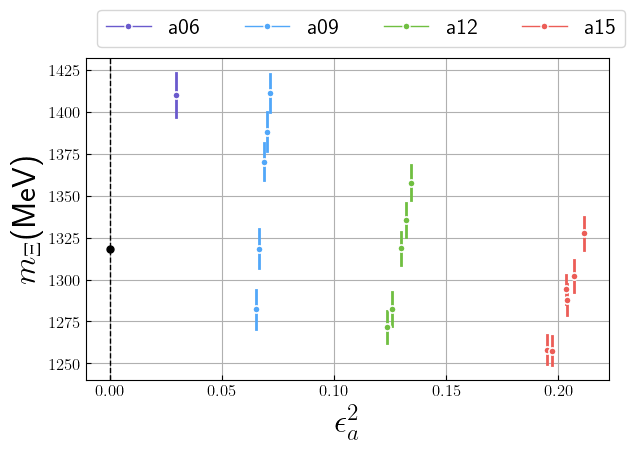

Model: xi:xi_st:d_n2lo:l_nlo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -149.58

Parameters:
       m_{xi,0}       1327 (21)      [    1000 (400) ]  
         s_{xi}       1.23 (52)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.34 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
      g_{xi,xi}   0.009 (3.974)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.1 (2.3)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1529 (29)      [    1300 (400) ]  
       a_{xi,4}      -0.8 (1.6)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.55 (58)      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.11 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}      -0.3 (1.5)      [    -0.8 (2.0) ]  
    a_{xi_st,4}      -0.2 (1.5)      [     0.0 (2.0) ]  
       eps2_a 0   0.

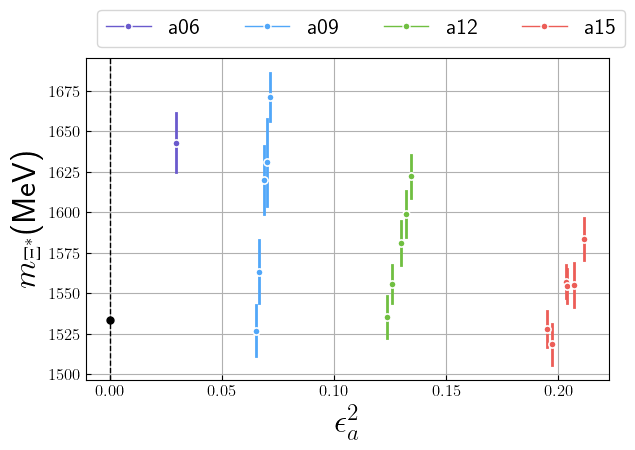

Model: xi:xi_st:d_n2lo:l_nlo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.42 [34]    Q = 1    logGBF = -149.58

Parameters:
       m_{xi,0}       1327 (21)      [    1000 (400) ]  
         s_{xi}       1.23 (52)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.67 (19)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.34 (26)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
      g_{xi,xi}   0.009 (3.974)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.1 (2.3)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1529 (29)      [    1300 (400) ]  
       a_{xi,4}      -0.8 (1.6)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.55 (58)      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.08 (23)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.11 (82)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.0 (1.3)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}      -0.3 (1.5)      [    -0.8 (2.0) ]  
    a_{xi_st,4}      -0.2 (1.5)      [     0.0 (2.0) ]  
       eps2_a 0   0.

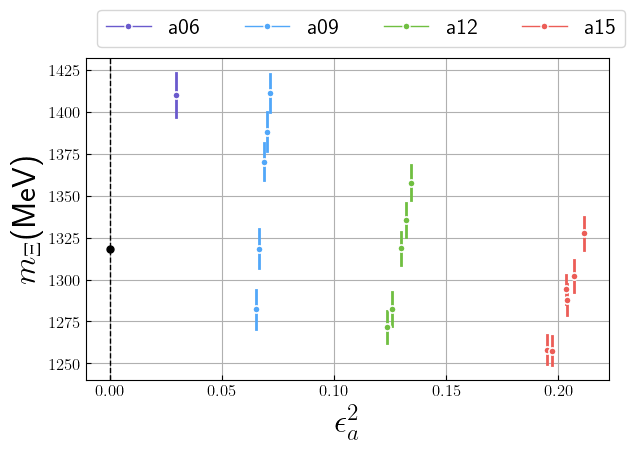

Model: xi:xi_st:d_n2lo:l_lo:s_lo
Least Square Fit:
  chi2/dof [dof] = 0.37 [34]    Q = 1    logGBF = -153.26

Parameters:
       m_{xi,0}       1316 (24)      [    1000 (400) ]  
         s_{xi}       1.63 (50)      [     0.0 (2.0) ]  
       b_{xi,4}    -0.02 (1.71)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.59 (23)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.21 (37)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
       d_{xi,s}       0.22 (39)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1536 (33)      [    1300 (400) ]  
     s_{xi,bar}       1.23 (72)      [     0.0 (2.0) ]  
    b_{xi_st,4}       1.5 (2.9)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.13 (27)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.4 (1.0)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.1 (1.4)      [     0.0 (5.0) ]  
    d_{xi_st,s}      -0.15 (44)      [     0.0 (5.0) ]  
          m_k 0     562.0 (5.0)      [   561.8 (5.0) ]  
              1     493

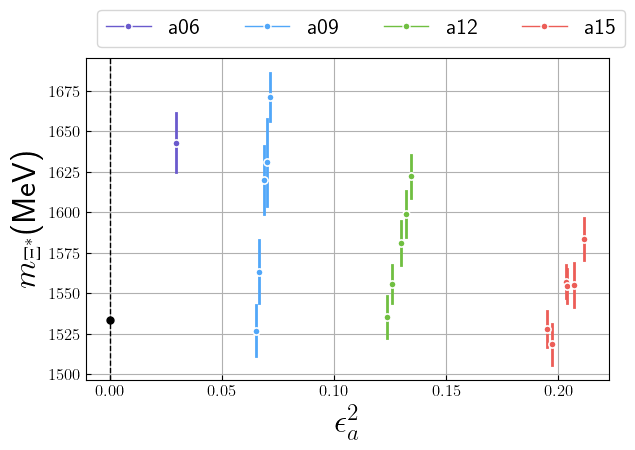

Model: xi:xi_st:d_n2lo:l_lo:s_lo
Least Square Fit:
  chi2/dof [dof] = 0.37 [34]    Q = 1    logGBF = -153.26

Parameters:
       m_{xi,0}       1316 (24)      [    1000 (400) ]  
         s_{xi}       1.63 (50)      [     0.0 (2.0) ]  
       b_{xi,4}    -0.02 (1.71)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.59 (23)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.21 (37)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
       d_{xi,s}       0.22 (39)      [     0.0 (5.0) ]  
    m_{xi_st,0}       1536 (33)      [    1300 (400) ]  
     s_{xi,bar}       1.23 (72)      [     0.0 (2.0) ]  
    b_{xi_st,4}       1.5 (2.9)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.13 (27)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.4 (1.0)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.1 (1.4)      [     0.0 (5.0) ]  
    d_{xi_st,s}      -0.15 (44)      [     0.0 (5.0) ]  
          m_k 0     562.0 (5.0)      [   561.8 (5.0) ]  
              1     493

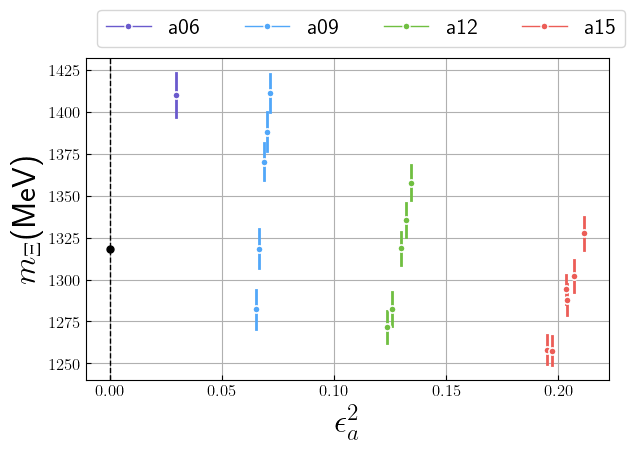

Model: xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.37 [34]    Q = 1    logGBF = -154.69

Parameters:
       m_{xi,0}       1317 (27)      [    1000 (400) ]  
         s_{xi}       1.65 (92)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.59 (24)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.21 (39)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
       d_{xi,s}       0.22 (42)      [     0.0 (5.0) ]  
      g_{xi,xi}     0.02 (3.97)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.3 (1.2)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1538 (35)      [    1300 (400) ]  
       a_{xi,4}      -0.4 (1.9)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.10 (98)      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.13 (28)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.4 (1.1)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.1 (1.4)      [     0.0 (5.0) ]  
    d_{xi_st,s}      -0.16 (45)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}

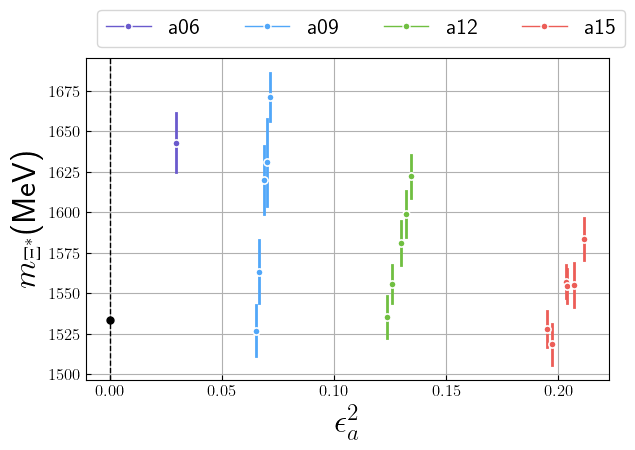

Model: xi:xi_st:d_n2lo:l_nlo:s_lo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.37 [34]    Q = 1    logGBF = -154.69

Parameters:
       m_{xi,0}       1317 (27)      [    1000 (400) ]  
         s_{xi}       1.65 (92)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.59 (24)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.21 (39)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
       d_{xi,s}       0.22 (42)      [     0.0 (5.0) ]  
      g_{xi,xi}     0.02 (3.97)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.3 (1.2)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1538 (35)      [    1300 (400) ]  
       a_{xi,4}      -0.4 (1.9)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.10 (98)      [     0.0 (2.0) ]  
    d_{xi_st,a}      -0.13 (28)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.4 (1.1)      [     0.0 (5.0) ]  
   d_{xi_st,al}      -4.1 (1.4)      [     0.0 (5.0) ]  
    d_{xi_st,s}      -0.16 (45)      [     0.0 (5.0) ]  
g_{xi_st,xi_st}

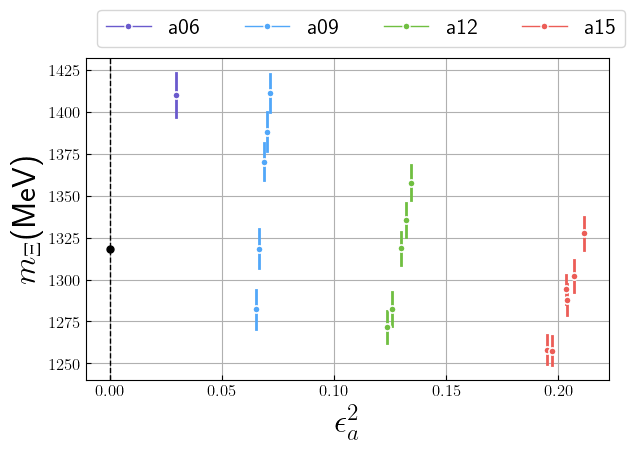

Model: xi:xi_st:d_n2lo:l_n2lo:s_lo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.37 [34]    Q = 1    logGBF = -154.65

Parameters:
       m_{xi,0}       1318 (27)      [    1000 (400) ]  
         s_{xi}       1.59 (95)      [     0.0 (2.0) ]  
       b_{xi,4}    -0.01 (1.94)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.60 (24)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.22 (39)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
       d_{xi,s}       0.20 (42)      [     0.0 (5.0) ]  
      g_{xi,xi}     0.02 (3.97)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.3 (1.6)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1539 (36)      [    1300 (400) ]  
       a_{xi,4}      -0.4 (1.9)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.1 (1.0)      [     0.0 (2.0) ]  
    b_{xi_st,4}       1.0 (4.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.14 (28)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.4 (1.1)      [     0.0 (5.0) ]  
   d_{xi_st,al

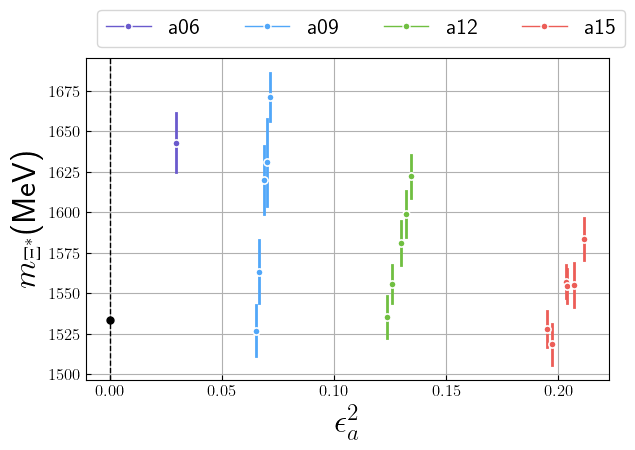

Model: xi:xi_st:d_n2lo:l_n2lo:s_lo:x_n2lo
Least Square Fit:
  chi2/dof [dof] = 0.37 [34]    Q = 1    logGBF = -154.65

Parameters:
       m_{xi,0}       1318 (27)      [    1000 (400) ]  
         s_{xi}       1.59 (95)      [     0.0 (2.0) ]  
       b_{xi,4}    -0.01 (1.94)      [     0.0 (2.0) ]  
       d_{xi,a}      -0.60 (24)      [    -2.0 (2.0) ]  
      d_{xi,aa}       1.22 (39)      [     2.0 (4.0) ]  
      d_{xi,al}      -3.4 (1.2)      [     0.0 (5.0) ]  
       d_{xi,s}       0.20 (42)      [     0.0 (5.0) ]  
      g_{xi,xi}     0.02 (3.97)      [     0.3 (4.0) ]  
   g_{xi_st,xi}       0.3 (1.6)      [     0.7 (3.0) ]  
    m_{xi_st,0}       1539 (36)      [    1300 (400) ]  
       a_{xi,4}      -0.4 (1.9)      [     0.0 (2.0) ]  
     s_{xi,bar}       1.1 (1.0)      [     0.0 (2.0) ]  
    b_{xi_st,4}       1.0 (4.4)      [     0.0 (5.0) ]  
    d_{xi_st,a}      -0.14 (28)      [     0.0 (2.0) ]  
   d_{xi_st,aa}       0.4 (1.1)      [     0.0 (5.0) ]  
   d_{xi_st,al

In [ ]:

importlib.reload(xfa)
importlib.reload(fit)
importlib.reload(i_o)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    for part in mdl_info['particles']:
        plot_params(fit=fit_out,yparam=part)
        print(f"Model: {mdl_key}")
        print(fit_out)

    # print(extrap_analysis)

    # return fit_out

with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
for mdl_key in xi_models:
    # mdl_info = xi_models[mdl_key]
    try:
        perform_fit_and_plot(xi_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    


## Xi, Xi* system SU(2) HBXPT extrapolation ##


NameError: name 'extrap_analysis' is not defined

In [ ]:
from scipy.interpolate import interp1d
importlib.reload(xfa)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.fit_analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    print(fit_out)
    print(f"Model: {mdl_key}")
    print(extrap_analysis)

    # x_data = [gv.mean(x) for x in extrap_analysis.fit.p['eps2_a']]
    # for part in mdl_info['particles']:
    #     y_data = [gv.mean(y) for y in extrap_analysis.fit.y[part]]

    # y_fit = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')

    # x_fit = np.linspace(-0.1, 0.1, 100)
    # y_fit_vals = [y_fit(x) for x in x_fit]

    # plt.plot(x_fit, y_fit_vals, label=f"{mdl_key}")
    # plt.fill_between(x_fit, [y - gv.sdev(y) for y in y_fit_vals], [y + gv.sdev(y) for y in y_fit_vals], alpha=0.5)

    # plt.axvline(0, ls='--', color='black', label='phys. point')
    # y_phys = np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']])
    
    # plt.plot(0, gv.mean(y_phys), marker='o', mec='w', zorder=0.2, color='black')

    # plt.xlabel("$\epsilon_a^2$")
    # plt.ylabel("$m_\Xi(MeV)$")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return fit_out


In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    try:
        perform_fit_and_plot(lam_sig_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    

Error encountered for Model: lam:sigma:sigma_st:l_lo:d_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_n2lo:d_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_n2lo:d_n2lo:x_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_nlo:d_n2lo:x_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_lo:d_n2lo:s_lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_n2lo:d_n2lo:s_lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_nlo:s_lo:d_n2lo:x_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Mod

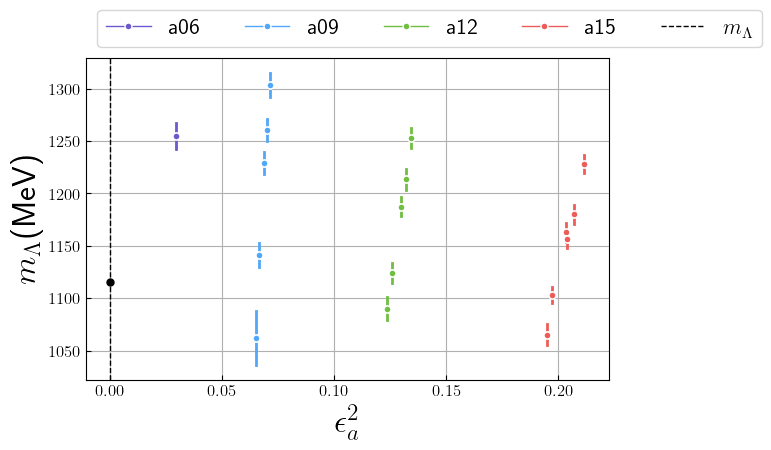

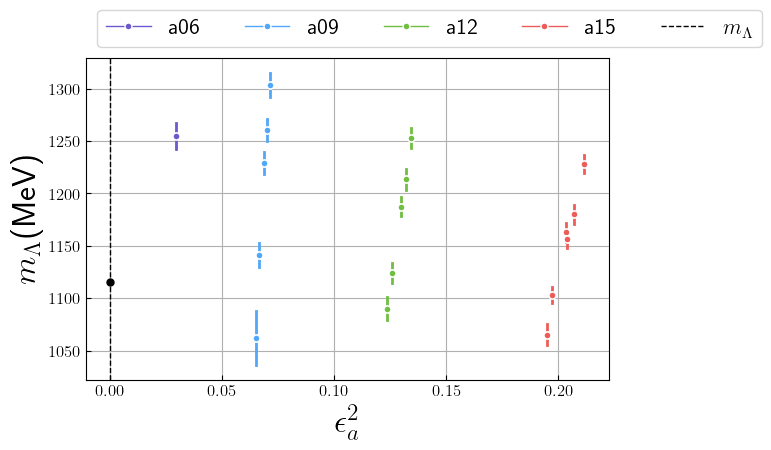

In [ ]:
lam_sig_models = models['models']['lam_sigma_system']
model_info = lam_sig_models['lam:sigma:sigma_st:l_lo:d_n2lo:s_lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)
lam_sigma_sys_out = my_fit.fit
plot_params(fit=lam_sigma_sys_out,yparam='lambda')

In [ ]:
lam_sigma_fit = perform_fit_and_plot(model_type=mod)
plot_params()

NameError: name 'mod' is not defined

### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation

In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    perform_fit_and_plot(lam_sig_models,mdl_key)

Model: lam:sigma:sigma_st:l_n2lo:s_n2lo:d_n2lo:x_n2lo

---
Least Square Fit:
  chi2/dof [dof] = 0.99 [51]    Q = 0.49    logGBF = -247.67

Parameters:
         m_{lambda,0}         1039.01 +- 26.9751            [               1000 +- 50 ]  
           s_{lambda}          2.1043 +- 1.00877            [                   0 +- 5 ]  
         b_{lambda,4}        0.882997 +- 4.37478            [                   0 +- 5 ]  
         d_{lambda,a}      0.0539212 +- 0.312282            [                   0 +- 5 ]  
        d_{lambda,aa}       -0.149455 +- 1.18896            [                   0 +- 5 ]  
        d_{lambda,al}        -3.55825 +- 3.39301            [                   0 +- 5 ]  
         d_{lambda,s}       -1.02076 +- 0.783243            [                   0 +- 5 ]  
        d_{lambda,as}         4.15861 +- 3.30558            [                   0 +- 5 ]  
        d_{lambda,ls}          2.4444 +- 4.66278            [                   0 +- 5 ]  
        d_{lambda,ss}        -

KeyError: 'undefined key: a_{sigma,4}'